<a href="https://colab.research.google.com/github/sayakpaul/BERT-for-Mobile/blob/master/DistilBERT_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook is copied from [here](https://github.com/dipanjanS/deep_transfer_learning_nlp_dhs2019/blob/master/notebooks/6%20-%20Transformers%20-%20DistilBERT.ipynb). The purpose of this notebook is to show how to convert a custom DistilBERT-based model to TensorFlow Lite.*

In [ ]:
!nvidia-smi

Mon Sep 28 02:42:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [ ]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset['sentiment'] = [1 if record == 'positive' else 0 for record in dataset['sentiment']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:5000]
val_reviews = reviews [5000:10000]
test_reviews = reviews[10000:]



train_sentiments = sentiments[:5000]
val_sentiments = sentiments [5000:10000]
test_sentiments = sentiments[10000:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((5000,), (5000,), (40000,))

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
import tqdm

def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [ ]:
MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 500, 768),)  66362880    bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]           
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_distil_bert_model[0

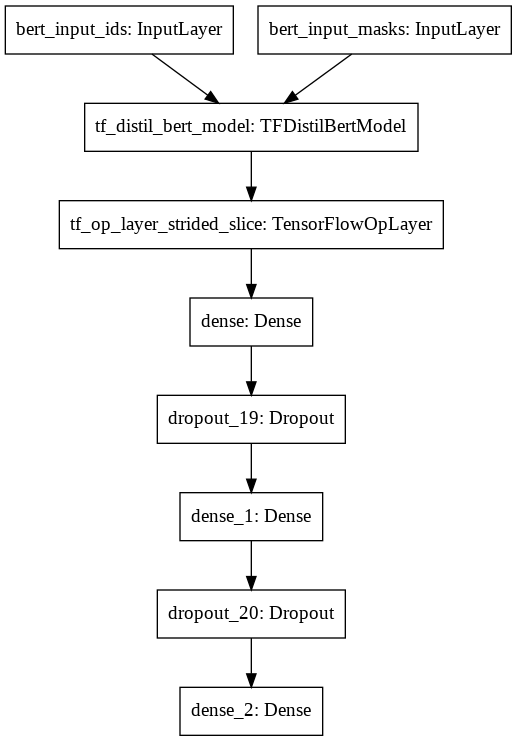

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

In [ ]:
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_reviews, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, val_reviews, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Converting docs to features: 100%|██████████| 5000/5000 [00:15<00:00, 317.48it/s]

Train Features: (5000, 500) (5000, 500)
Val Features: (5000, 500) (5000, 500)


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=1,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids, 
           train_features_masks], train_sentiments, 
          validation_data=([val_features_ids, 
                            val_features_masks], val_sentiments),
          epochs=3, 
          batch_size=20, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

Epoch 1/3
 287/3368 [=>............................] - ETA: 32:44 - loss: 0.3755 - accuracy: 0.8284

In [ ]:
model.save_weights('distillbert_ft_wts.h5')

In [ ]:
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_reviews, 
                                                                    max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 40000/40000 [02:06<00:00, 316.42it/s]

Test Features: (40000, 500) (40000, 500)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks], batch_size=200, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Accuracy: 90.23%
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     20028
           1       0.88      0.93      0.90     19972

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



,0,1
0,17519,2509
1,1399,18573


Reference - https://github.com/huggingface/tflite-android-transformers/blob/master/models_generation/distilbert.py

### Dynamic-range

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("distilbert_imdb_tflite.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkbgna3py/assets


INFO:tensorflow:Assets written to: /tmp/tmpkbgna3py/assets
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


68119632

In [ ]:
!ls -lh distilbert_imdb_tflite.tflite

-rw-r--r-- 1 root root 65M Sep 28 03:06 distilbert_imdb_tflite.tflite


### Float16

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("distilbert_imdb_tflite_fp16.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiyod2xk5/assets


INFO:tensorflow:Assets written to: /tmp/tmpiyod2xk5/assets
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


133416688

In [ ]:
!ls -lh distilbert_imdb_tflite_fp16.tflite

-rw-r--r-- 1 root root 128M Sep 28 03:08 distilbert_imdb_tflite_fp16.tflite


### Integer

In [ ]:
# model.load_weights("distillbert_ft_wts.h5")

In [ ]:
# ==============Representative dataset====================
train_features_ids = train_features_ids.astype(np.int32)
train_features_masks = train_features_masks.astype(np.int32)
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features_ids, 
    train_features_masks))

def representative_dataset_gen():
    for feature_id, feature_mask in train_tf_dataset.take(10):
        yield [feature_id, feature_mask]

# ==============Conversion====================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.representative_dataset = representative_dataset_gen
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("distilbert_imdb_tflite_int.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmps631nxwi/assets


***Currently, integer quantization fails.***